In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms, models
import timm  # for pre-trained ViT models (make sure timm is installed: pip install timm)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import copy
import os








# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [10]:


# Data augmentation and normalization for training and validation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2470, 0.2435, 0.2616))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4942, 0.4851, 0.4504), 
                         (0.2467, 0.2429, 0.2616))
])












# Download CIFAR-10 dataset
data_root = './data'
train_dataset = datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform_test)

# Create training and validation split from train dataset (80%-20%)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = train_dataset.classes

In [11]:











# 2.1. Custom CNN Model
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 32x32 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32x32 -> 16x16
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 16x16 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16 -> 8x8
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 8x8 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8 -> 4x4
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [12]:
# 2.2. Vision Transformer (ViT) Implementation from Scratch
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=128):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        # x shape: [B, C, H, W]
        x = self.proj(x)  # shape becomes [B, embed_dim, H/patch_size, W/patch_size]
        x = x.flatten(2)  # [B, embed_dim, n_patches]
        x = x.transpose(1, 2)  # [B, n_patches, embed_dim]
        return x







class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, mlp_ratio=4.0, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(mlp_ratio * embed_dim)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(mlp_ratio * embed_dim), embed_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        # Self-attention block with residual
        x2 = self.norm1(x)
        attn_output, _ = self.attn(x2, x2, x2)
        x = x + attn_output
        
        # Feed-forward network with residual
        x2 = self.norm2(x)
        x = x + self.mlp(x2)
        return x






class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=128, depth=6, num_heads=4, mlp_ratio=4.0, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        n_patches = self.patch_embed.n_patches
        
        # Create learnable [class] token and add positional embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.pos_dropout = nn.Dropout(p=dropout)
        
        # Transformer encoder blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        # Final classification head
        self.head = nn.Linear(embed_dim, num_classes)
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        # You can initialize other parameters as desired.
    
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # [B, n_patches, embed_dim]
        # prepend class token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, n_patches+1, embed_dim]
        x = x + self.pos_embed
        x = self.pos_dropout(x)
        # Transformer encoder
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        # Use the class token for classification
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

In [13]:
# 2.3. Pre-trained ViT Fine-Tuning using timm 
# We choose a small ViT model from timm and adapt it to CIFAR-10. 
# Note that CIFAR-10 images are 32x32 so we perform an upsample transformation during preprocessing.
class PretrainedViTWrapper(nn.Module):
    def __init__(self, model_name='vit_small_patch16_224', num_classes=10, pretrained=True):
        super(PretrainedViTWrapper, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        # Replace head for CIFAR-10
        in_features = self.model.head.in_features
        self.model.head = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [14]:


def train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=1, early_stop_patience=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []
    
    patience = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
                dataloader = dataloaders['train']
            else:
                model.eval()   # set model to evaluate mode
                dataloader = dataloaders['val']
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                # scheduler step if using validation loss (or accuracy)
                if scheduler is not None:
                    scheduler.step(epoch_loss)
                
                # Early stopping check
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience = 0
                else:
                    patience += 1
                    if patience >= early_stop_patience:
                        print("Early stopping triggered")
                        model.load_state_dict(best_model_wts)
                        time_elapsed = time.time() - since
                        print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
                        return model, (train_loss_history, train_acc_history, val_loss_history, val_acc_history)
        
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_val_acc:.4f}')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (train_loss_history, train_acc_history, val_loss_history, val_acc_history)

def evaluate_model(model, dataloader, device):
    model.eval()
    running_corrects = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    acc = running_corrects.double() / len(dataloader.dataset)
    return acc.item(), all_labels, all_preds

def plot_training_curves(history, model_name):
    train_loss, train_acc, val_loss, val_acc = history
    epochs = range(1, len(train_loss)+1)
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

def display_confusion(all_labels, all_preds, classes, title="Confusion Matrix"):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()


Training Custom CNN Model:
Epoch 1/100
----------
Train Loss: 1.7718 Acc: 0.3443
Val Loss: 1.5086 Acc: 0.4525

Epoch 2/100
----------
Train Loss: 1.4826 Acc: 0.4522
Val Loss: 1.2586 Acc: 0.5277

Epoch 3/100
----------
Train Loss: 1.3389 Acc: 0.5111
Val Loss: 1.1576 Acc: 0.5788

Epoch 4/100
----------
Train Loss: 1.2391 Acc: 0.5540
Val Loss: 1.1199 Acc: 0.5950

Epoch 5/100
----------
Train Loss: 1.1817 Acc: 0.5769
Val Loss: 1.0762 Acc: 0.6106

Epoch 6/100
----------
Train Loss: 1.1288 Acc: 0.5987
Val Loss: 0.9640 Acc: 0.6546

Epoch 7/100
----------
Train Loss: 1.0924 Acc: 0.6146
Val Loss: 0.9467 Acc: 0.6654

Epoch 8/100
----------
Train Loss: 1.0562 Acc: 0.6275
Val Loss: 0.8986 Acc: 0.6846

Epoch 9/100
----------
Train Loss: 1.0153 Acc: 0.6423
Val Loss: 0.9110 Acc: 0.6841

Epoch 10/100
----------
Train Loss: 0.9869 Acc: 0.6537
Val Loss: 0.8513 Acc: 0.6987

Epoch 11/100
----------
Train Loss: 0.9612 Acc: 0.6616
Val Loss: 0.8295 Acc: 0.7049

Epoch 12/100
----------
Train Loss: 0.9450 Acc

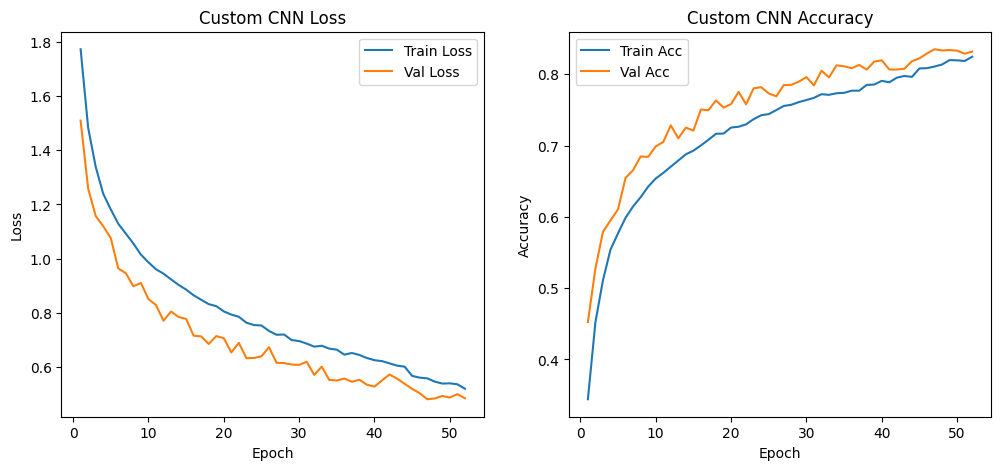

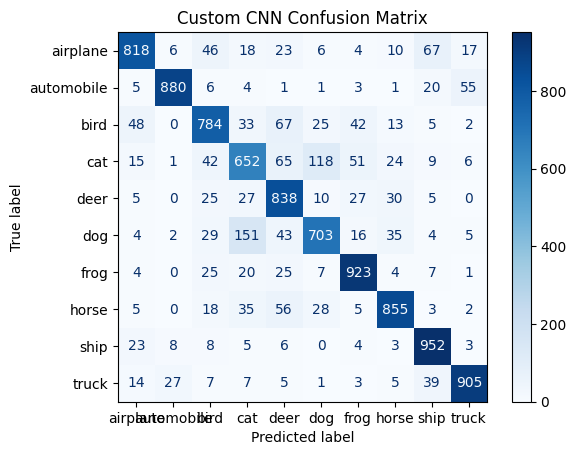

In [15]:
# ----------------------------
# 4. Training and Evaluation
# ----------------------------

num_epochs = 100   # you can adjust
learning_rate = 0.001

# Dictionary to store results for each model
results = {}

# ----------------------------
# 4.1 Train and Evaluate Custom CNN
# ----------------------------
print("\nTraining Custom CNN Model:")
cnn_model = CustomCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
dataloaders = {'train': train_loader, 'val': val_loader}

cnn_model, cnn_history = train_model(cnn_model, criterion, optimizer, scheduler,
                                       dataloaders, device, num_epochs=num_epochs, early_stop_patience=5)
train_acc, _, _ = evaluate_model(cnn_model, train_loader, device)
val_acc, cnn_labels, cnn_preds = evaluate_model(cnn_model, val_loader, device)
print(f"Custom CNN Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
results['Custom CNN'] = {'model': cnn_model, 'history': cnn_history, 'val_acc': val_acc}
plot_training_curves(cnn_history, "Custom CNN")
display_confusion(cnn_labels, cnn_preds, classes, title="Custom CNN Confusion Matrix")


Training Vision Transformer (from scratch):
Epoch 1/100
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 1.8334 Acc: 0.3067
Val Loss: 1.6474 Acc: 0.3892

Epoch 2/100
----------
Train Loss: 1.5671 Acc: 0.4199
Val Loss: 1.4349 Acc: 0.4756

Epoch 3/100
----------
Train Loss: 1.4517 Acc: 0.4651
Val Loss: 1.4257 Acc: 0.4883

Epoch 4/100
----------
Train Loss: 1.3689 Acc: 0.4979
Val Loss: 1.3304 Acc: 0.5131

Epoch 5/100
----------
Train Loss: 1.3215 Acc: 0.5195
Val Loss: 1.2836 Acc: 0.5358

Epoch 6/100
----------
Train Loss: 1.2777 Acc: 0.5346
Val Loss: 1.2456 Acc: 0.5479

Epoch 7/100
----------
Train Loss: 1.2409 Acc: 0.5464
Val Loss: 1.2398 Acc: 0.5613

Epoch 8/100
----------
Train Loss: 1.2060 Acc: 0.5634
Val Loss: 1.1881 Acc: 0.5786

Epoch 9/100
----------
Train Loss: 1.1743 Acc: 0.5710
Val Loss: 1.1756 Acc: 0.5756

Epoch 10/100
----------
Train Loss: 1.1468 Acc: 0.5825
Val Loss: 1.1400 Acc: 0.5913

Epoch 11/100
----------
Train Loss: 1.1088 Acc: 0.5977
Val Loss: 1.1048 Acc: 0.6044

Epoch 12/100
----------
Train Loss: 1.0844 Acc: 0.6097
Val Loss: 1.0623 Acc: 0.6252

Epoch 13/100

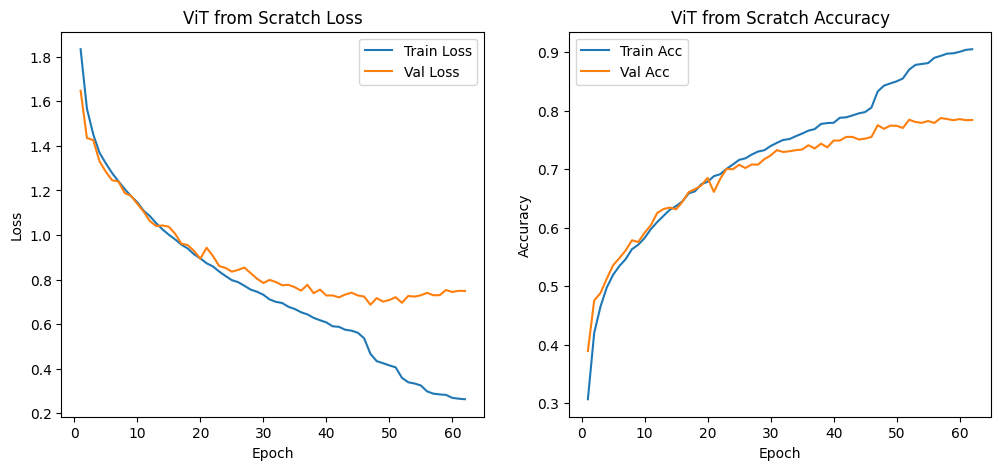

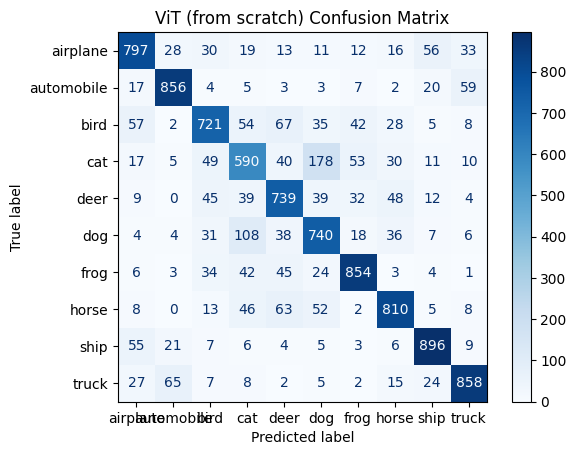

In [16]:
# ----------------------------
# 4.2 Train and Evaluate ViT from Scratch
# ----------------------------
print("\nTraining Vision Transformer (from scratch):")
vit_model = VisionTransformer(img_size=32, patch_size=4, in_channels=3,
                              num_classes=10, embed_dim=128, depth=6, num_heads=4,
                              mlp_ratio=4, dropout=0.1).to(device)
optimizer_vit = optim.Adam(vit_model.parameters(), lr=learning_rate)
scheduler_vit = lr_scheduler.ReduceLROnPlateau(optimizer_vit, mode='min', factor=0.5, patience=3, verbose=True)

vit_model, vit_history = train_model(vit_model, criterion, optimizer_vit, scheduler_vit,
                                       dataloaders, device, num_epochs=num_epochs, early_stop_patience=5)
train_acc, _, _ = evaluate_model(vit_model, train_loader, device)
val_acc, vit_labels, vit_preds = evaluate_model(vit_model, val_loader, device)
print(f"ViT (from scratch) Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
results['ViT Scratch'] = {'model': vit_model, 'history': vit_history, 'val_acc': val_acc}
plot_training_curves(vit_history, "ViT from Scratch")
display_confusion(vit_labels, vit_preds, classes, title="ViT (from scratch) Confusion Matrix")

In [ ]:
# ----------------------------
# 4.3 Fine-tune Pre-Trained ViT
# ----------------------------
num_epochs = 50
# For pretrained ViT we need to upsample CIFAR-10 images to the expected input size (224x224)
transform_train_pre = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test_pre = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset_pre = datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform_train_pre)
test_dataset_pre = datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform_test_pre)
train_size_pre = int(0.8 * len(train_dataset_pre))
val_size_pre = len(train_dataset_pre) - train_size_pre
train_ds_pre, val_ds_pre = random_split(train_dataset_pre, [train_size_pre, val_size_pre])
train_loader_pre = DataLoader(train_ds_pre, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_pre = DataLoader(val_ds_pre, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_pre = DataLoader(test_dataset_pre, batch_size=batch_size, shuffle=False, num_workers=2)
dataloaders_pre = {'train': train_loader_pre, 'val': val_loader_pre}

print("\nFine-tuning Pre-trained ViT Model:")
pretrained_vit = PretrainedViTWrapper(model_name='vit_small_patch16_224', num_classes=10, pretrained=True).to(device)
optimizer_pre = optim.Adam(pretrained_vit.parameters(), lr=learning_rate)
scheduler_pre = lr_scheduler.ReduceLROnPlateau(optimizer_pre, mode='min', factor=0.5, patience=3, verbose=True)

pretrained_vit, vit_pre_history = train_model(pretrained_vit, criterion, optimizer_pre, scheduler_pre,
                                                dataloaders_pre, device, num_epochs=num_epochs, early_stop_patience=5)
train_acc, _, _ = evaluate_model(pretrained_vit, train_loader_pre, device)
val_acc, vit_pre_labels, vit_pre_preds = evaluate_model(pretrained_vit, val_loader_pre, device)
print(f"Pre-trained ViT Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
results['Pre-trained ViT'] = {'model': pretrained_vit, 'history': vit_pre_history, 'val_acc': val_acc}
plot_training_curves(vit_pre_history, "Pre-trained ViT")
display_confusion(vit_pre_labels, vit_pre_preds, classes, title="Pre-trained ViT Confusion Matrix")


Fine-tuning Pre-trained ViT Model:


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch 1/50
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 1.6487 Acc: 0.3971
Val Loss: 1.2629 Acc: 0.5538

Epoch 2/50
----------
Train Loss: 0.9758 Acc: 0.6523
Val Loss: 0.8259 Acc: 0.7135

Epoch 3/50
----------
Train Loss: 0.7621 Acc: 0.7308
Val Loss: 0.8082 Acc: 0.7108

Epoch 4/50
----------
Train Loss: 0.6299 Acc: 0.7787
Val Loss: 0.6454 Acc: 0.7778

Epoch 5/50
----------
Train Loss: 0.5405 Acc: 0.8118
Val Loss: 0.5946 Acc: 0.7924

Epoch 6/50
----------
Train Loss: 0.4715 Acc: 0.8344
Val Loss: 0.5392 Acc: 0.8124

Epoch 7/50
----------
Train Loss: 0.4181 Acc: 0.8543
Val Loss: 0.5156 Acc: 0.8244

Epoch 8/50
----------
Train Loss: 0.3785 Acc: 0.8680
Val Loss: 0.4610 Acc: 0.8354

Epoch 9/50
----------


In [ ]:
# ----------------------------
# 6. Visualizing Sample Predictions for ViT and Pre-trained ViT
# ----------------------------
def show_sample_predictions(model, dataloader, device, classes, n_samples=8):
    model.eval()
    images, labels, preds = [], [], []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            images.extend(inputs.cpu())
            labels.extend(targets.cpu())
            preds.extend(predictions.cpu())
            if len(images) >= n_samples:
                break
    images = images[:n_samples]
    labels = labels[:n_samples]
    preds = preds[:n_samples]
    
    plt.figure(figsize=(15,3))
    for idx in range(n_samples):
        img = images[idx]
        # if the model has been trained on normalized images, we need to unnormalize to show properly
        img_np = img.permute(1,2,0).numpy()
        # Adjust based on normalization values (this example uses CIFAR means/std for the custom CNN/ViT scratch)
        img_np = img_np * np.array([0.2470, 0.2435, 0.2616]) + np.array([0.4914, 0.4822, 0.4465])
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(1, n_samples, idx+1)
        plt.imshow(img_np)
        plt.title(f"GT: {classes[labels[idx]]}\nPred: {classes[preds[idx]]}")
        plt.axis('off')
    plt.suptitle("Sample Predictions")
    plt.show()

# Example: display sample predictions from the custom CNN on test set
print("\nSample Predictions from Custom CNN:")
_, test_labels, test_preds = evaluate_model(cnn_model, test_loader, device)
show_sample_predictions(cnn_model, test_loader, device, classes)



def show_sample_predictions_custom(model, dataloader, device, classes, n_samples=8,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2470, 0.2435, 0.2616])):
    """
    Display sample predictions with a custom unnormalization for models
    (e.g., Custom CNN or ViT from scratch).
    """
    model.eval()
    images, labels, preds = [], [], []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            images.extend(inputs.cpu())
            labels.extend(targets.cpu())
            preds.extend(predictions.cpu())
            if len(images) >= n_samples:
                break
    images = images[:n_samples]
    labels = labels[:n_samples]
    preds = preds[:n_samples]
    
    plt.figure(figsize=(15,3))
    for idx in range(n_samples):
        img = images[idx]
        # Unnormalize the image
        img_np = img.permute(1,2,0).numpy()
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(1, n_samples, idx+1)
        plt.imshow(img_np)
        plt.title(f"GT: {classes[labels[idx]]}\nPred: {classes[preds[idx]]}")
        plt.axis('off')
    plt.suptitle("Sample Predictions")
    plt.show()

def show_sample_predictions_pretrained(model, dataloader, device, classes, n_samples=8,
                                       mean=np.array([0.5, 0.5, 0.5]),
                                       std=np.array([0.5, 0.5, 0.5])):
    """
    Display sample predictions for the pre-trained model with the corresponding
    unnormalization.
    """
    model.eval()
    images, labels, preds = [], [], []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            images.extend(inputs.cpu())
            labels.extend(targets.cpu())
            preds.extend(predictions.cpu())
            if len(images) >= n_samples:
                break
    images = images[:n_samples]
    labels = labels[:n_samples]
    preds = preds[:n_samples]
    
    plt.figure(figsize=(15,3))
    for idx in range(n_samples):
        img = images[idx]
        # Unnormalize the image for pre-trained ViT transform (mean=std=0.5)
        img_np = img.permute(1,2,0).numpy()
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(1, n_samples, idx+1)
        plt.imshow(img_np)
        plt.title(f"GT: {classes[labels[idx]]}\nPred: {classes[preds[idx]]}")
        plt.axis('off')
    plt.suptitle("Sample Predictions (Pre-trained ViT)")
    plt.show()

# Visualize predictions for ViT (from scratch)
print("\nSample Predictions from Vision Transformer (from scratch):")
_, vit_test_labels, vit_test_preds = evaluate_model(vit_model, test_loader, device)
show_sample_predictions_custom(vit_model, test_loader, device, classes, n_samples=8)

# Visualize predictions for Pre-trained ViT
print("\nSample Predictions from Pre-trained ViT:")
_, vit_pre_test_labels, vit_pre_test_preds = evaluate_model(pretrained_vit, test_loader_pre, device)
show_sample_predictions_pretrained(pretrained_vit, test_loader_pre, device, classes, n_samples=8)